In [1]:
import torch
import os
import shutil
import sys
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import eval_utils,utils
import time

import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer

from vaecf import MultiVAE
import models

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## ItemPopularity Experiment

In [2]:
def test_item_popularity(train_data, testRatings, testNegatives, topk=10, limit=100000):
    item_pop = {}
    for i in range(n_items):
        item_pop[i] = train_data[:,i].count_nonzero()
    item_pop_evaluation = eval_utils.item_popularity_evaluation(item_pop, testRatings, testNegatives, topk)
    (hits, ndcgs) = item_pop_evaluation.evaluate(num_thread=1, limit_size=limit)
    item_pop_hr, item_pop_ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print 'Item Popularity, testSize=%d, HitRate=%.4f, NDCG=%.4f' % (len(hits), item_pop_hr, item_pop_ndcg)
    return item_pop_hr, item_pop_ndcg

## ItemCF Experiment

In [3]:
def test_itemcf(dataset_name, testRatings, testNegatives, topk=10, limit=100000, alpha=0.5, Q=1, knn=1000):
    
    u2s = dict()
    s2u = dict()

    train_file = '../train/%s.train.rating' % dataset_name
    with open(train_file, 'r') as f:
        for line in f:
            if line != None and line != "":
                arr = line.split("\t")
                user, song = int(arr[0]), int(arr[1])
                if user not in u2s:
                    u2s[user] = set()
                u2s[user].add(song)
                if song not in s2u:
                    s2u[song] = set()
                s2u[song].add(user)

    model = models.ItemCF(u2s, s2u, sim_method='cos', alpha=alpha, Q=Q, knn=knn)

    itemcf_eval = eval_utils.itemcf_evaluation(model, u2s, testRatings, testNegatives, K=topk)
    (hits, ndcgs) = itemcf_eval.evaluate(num_thread=1, limit_size=limit)
    itemcf_hr, itemcf_ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('ItemCF, testSize = %d, HR = %.4f, NDCG = %.4f'  % (len(hits), itemcf_hr, itemcf_ndcg))
    return itemcf_hr, itemcf_ndcg

In [6]:
alphas = []
alpha_hrs = []
alpha_ndcg = []
Q = 1
for alpha in np.arange(0,2,0.05):
    itemcf_hr, itemcf_ndcg = test_itemcf(dataset_name, testRatings, testNegatives, topk=10, limit=100000, alpha=alpha, Q=Q, knn=1000)
    alphas.append(alpha)
    alpha_hrs.append(itemcf_hr)
    alpha_ndcg.append(itemcf_ndcg)
    print('ItemCF, alpha = %.2f, HR = %.4f, NDCG = %.4f'  % (alpha, itemcf_hr, itemcf_ndcg))

Constructing ItemCF_cos
	Ranking Pop Items. tot: 1758
	Calc Item Similarity:cos,alpha=0.0,Q=1
ItemCF, alpha = 0.00, HR = 0.4509, NDCG = 0.2760
Constructing ItemCF_cos
	Ranking Pop Items. tot: 1758
	Calc Item Similarity:cos,alpha=0.05,Q=1
ItemCF, alpha = 0.05, HR = 0.4653, NDCG = 0.2892
Constructing ItemCF_cos
	Ranking Pop Items. tot: 1758
	Calc Item Similarity:cos,alpha=0.1,Q=1
ItemCF, alpha = 0.10, HR = 0.4793, NDCG = 0.3011
Constructing ItemCF_cos
	Ranking Pop Items. tot: 1758
	Calc Item Similarity:cos,alpha=0.15000000000000002,Q=1
ItemCF, alpha = 0.15, HR = 0.4908, NDCG = 0.3112
Constructing ItemCF_cos
	Ranking Pop Items. tot: 1758
	Calc Item Similarity:cos,alpha=0.2,Q=1
ItemCF, alpha = 0.20, HR = 0.5003, NDCG = 0.3192
Constructing ItemCF_cos
	Ranking Pop Items. tot: 1758
	Calc Item Similarity:cos,alpha=0.25,Q=1
ItemCF, alpha = 0.25, HR = 0.5077, NDCG = 0.3258
Constructing ItemCF_cos
	Ranking Pop Items. tot: 1758
	Calc Item Similarity:cos,alpha=0.30000000000000004,Q=1
ItemCF, alpha 

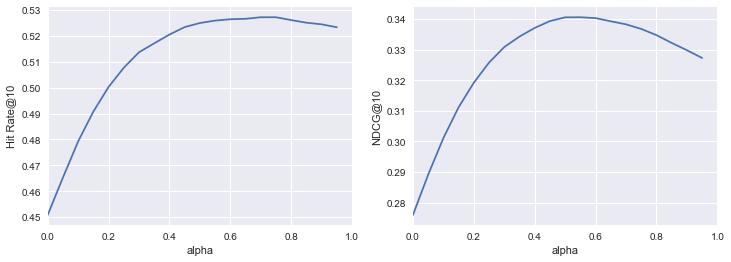

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(alphas, alpha_hrs)
ax1.set_ylabel("Hit Rate@%d" % topk)
ax1.set_xlabel("alpha")
ax1.set_xlim([0,1])

ax2.plot(alphas, alpha_ndcg)
ax2.set_ylabel("NDCG@%d" % topk)
ax2.set_xlabel("alpha")
ax2.set_xlim([0,1])

pass

In [5]:
params = []
p_hrs = []
p_ndcg = []
alpha = 0.5
dataset_name='msd-little'
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)

for param in np.arange(1,10,1):
    hr, ndcg = test_itemcf(dataset_name, testRatings, testNegatives, topk=10, limit=10000, alpha=alpha, Q=param, knn=1000)
    params.append(param)
    p_hrs.append(hr)
    p_ndcg.append(ndcg)
    print('ItemCF, alpha = %.2f, Q = %.1f, HR = %.4f, NDCG = %.4f'  % (alpha, param,hr, ndcg))

ItemCF, testSize = 10000, HR = 0.6495, NDCG = 0.4497
ItemCF, alpha = 0.50, Q = 1.0, HR = 0.6495, NDCG = 0.4497
ItemCF, testSize = 10000, HR = 0.6536, NDCG = 0.4546
ItemCF, alpha = 0.50, Q = 2.0, HR = 0.6536, NDCG = 0.4546
ItemCF, testSize = 10000, HR = 0.6497, NDCG = 0.4483
ItemCF, alpha = 0.50, Q = 3.0, HR = 0.6497, NDCG = 0.4483
ItemCF, testSize = 10000, HR = 0.6445, NDCG = 0.4425
ItemCF, alpha = 0.50, Q = 4.0, HR = 0.6445, NDCG = 0.4425
ItemCF, testSize = 10000, HR = 0.6410, NDCG = 0.4385
ItemCF, alpha = 0.50, Q = 5.0, HR = 0.6410, NDCG = 0.4385
ItemCF, testSize = 10000, HR = 0.6374, NDCG = 0.4351
ItemCF, alpha = 0.50, Q = 6.0, HR = 0.6374, NDCG = 0.4351
ItemCF, testSize = 10000, HR = 0.6358, NDCG = 0.4327
ItemCF, alpha = 0.50, Q = 7.0, HR = 0.6358, NDCG = 0.4327
ItemCF, testSize = 10000, HR = 0.6339, NDCG = 0.4310
ItemCF, alpha = 0.50, Q = 8.0, HR = 0.6339, NDCG = 0.4310
ItemCF, testSize = 10000, HR = 0.6327, NDCG = 0.4300
ItemCF, alpha = 0.50, Q = 9.0, HR = 0.6327, NDCG = 0.4300


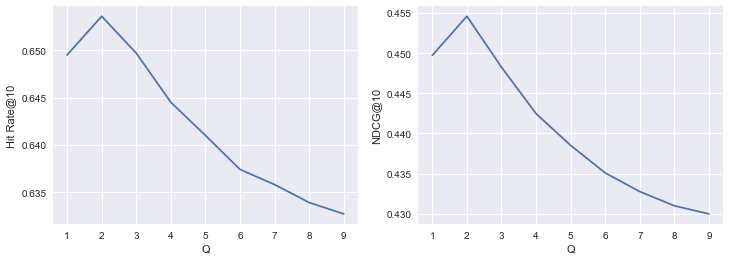

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
topk=10
ax1.plot(params, p_hrs)
ax1.set_ylabel("Hit Rate@%d" % topk)
ax1.set_xlabel("Q")

ax2.plot(params, p_ndcg)
ax2.set_ylabel("NDCG@%d" % topk)
ax2.set_xlabel("Q")

pass

## UserCF Experiment

In [8]:
def test_usercf(dataset_name, testRatings, testNegatives, topk=10, limit=100000, alpha=0.5, knn=500):
    u2s = dict()
    s2u = dict()

    train_file = '../train/%s.train.rating' % dataset_name
    print 'reading training file.'
    with open(train_file, 'r') as f:
        for line in f:
            if line != None and line != "":
                arr = line.split("\t")
                user, song = int(arr[0]), int(arr[1])
                if user not in u2s:
                    u2s[user] = set()
                u2s[user].add(song)
                if song not in s2u:
                    s2u[song] = set()
                s2u[song].add(user)
    
    model = models.UserCF(u2s, s2u, sim_method='cos', alpha=alpha, knn=knn)
    evaluator = eval_utils.usercf_evaluation(model, u2s, testRatings, testNegatives, K=topk)
    (hits, ndcgs) = evaluator.evaluate(num_thread=1, limit_size=limit)
    usercf_hr, usercf_ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('UserCF, knn = %d, HR = %.4f, NDCG = %.4f'  % (knn, usercf_hr, usercf_ndcg))
    return usercf_hr, usercf_ndcg

In [6]:
knns = []
knn_hrs = []
knn_ndcgs = []
dataset_name='msd-little'
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
for knn in np.arange(20,501,20):
    usercf_hr, usercf_ndcg = test_usercf(dataset_name, testRatings, testNegatives, topk=10, limit=10000, alpha=0.5, knn=knn)
    knns.append(knn)
    knn_hrs.append(usercf_hr)
    knn_ndcgs.append(usercf_ndcg)
    print('UserCF, knn = %d, HR = %.4f, NDCG = %.4f'  % (knn, usercf_hr, usercf_ndcg))

UserCF, knn = 20, HR = 0.2815, NDCG = 0.1775
UserCF, knn = 40, HR = 0.3412, NDCG = 0.2191
UserCF, knn = 60, HR = 0.3816, NDCG = 0.2460
UserCF, knn = 80, HR = 0.4046, NDCG = 0.2633
UserCF, knn = 100, HR = 0.4199, NDCG = 0.2755
UserCF, knn = 120, HR = 0.4316, NDCG = 0.2841
UserCF, knn = 140, HR = 0.4430, NDCG = 0.2915
UserCF, knn = 160, HR = 0.4535, NDCG = 0.2980
UserCF, knn = 180, HR = 0.4609, NDCG = 0.3022
UserCF, knn = 200, HR = 0.4693, NDCG = 0.3063
UserCF, knn = 220, HR = 0.4742, NDCG = 0.3091
UserCF, knn = 240, HR = 0.4792, NDCG = 0.3115
UserCF, knn = 260, HR = 0.4833, NDCG = 0.3134
UserCF, knn = 280, HR = 0.4864, NDCG = 0.3142
UserCF, knn = 300, HR = 0.4890, NDCG = 0.3154
UserCF, knn = 320, HR = 0.4921, NDCG = 0.3160
UserCF, knn = 340, HR = 0.4952, NDCG = 0.3166
UserCF, knn = 360, HR = 0.4975, NDCG = 0.3171
UserCF, knn = 380, HR = 0.4999, NDCG = 0.3178
UserCF, knn = 400, HR = 0.5009, NDCG = 0.3175
UserCF, knn = 420, HR = 0.5021, NDCG = 0.3178
UserCF, knn = 440, HR = 0.5030, NDCG =

In [9]:
p_knn_hrs = []
p_knn_ndcgs = []

for i,v in enumerate(knn_hrs):
    if i % 2 == 0:
        p_knn_hrs.append(v)
    else:
        p_knn_ndcgs.append(v)

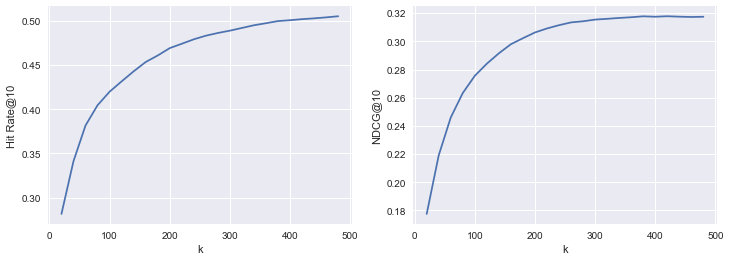

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(knns, p_knn_hrs)
ax1.set_ylabel("Hit Rate@%d" % topk)
ax1.set_xlabel("k")


ax2.plot(knns, p_knn_ndcgs)
ax2.set_ylabel("NDCG@%d" % topk)
ax2.set_xlabel("k")

# best: 400

pass

## Latent Factor Models with ALS

In [9]:
def nonzeros(m, row):
    """ returns the non zeroes of a row in csr_matrix """
    for index in range(m.indptr[row], m.indptr[row+1]):
        yield m.indices[index], m.data[index]

def alternating_least_squares(Cui, factors, regularization, iterations=20):
    users, items = Cui.shape

    X = np.random.rand(users, factors) * 0.01
    Y = np.random.rand(items, factors) * 0.01

    Ciu = Cui.T.tocsr()
    for iteration in range(iterations):
        least_squares(Cui, X, Y, regularization)
        least_squares(Ciu, Y, X, regularization)

    return X, Y

def least_squares(Cui, X, Y, regularization):
    users, factors = X.shape
    YtY = Y.T.dot(Y)

    for u in range(users):
        # accumulate YtCuY + regularization * I in A
        A = YtY + regularization * np.eye(factors)

        # accumulate YtCuPu in b
        b = np.zeros(factors)

        for i, confidence in nonzeros(Cui, u):
            factor = Y[i]
            A += (confidence - 1) * np.outer(factor, factor)
            b += confidence * factor

        # Xu = (YtCuY + regularization * I)^-1 (YtCuPu)
        X[u] = np.linalg.solve(A, b)
        
def test_mf_als(train_data, testRatings, testNegatives, n_epochs = 20, factors=64, topk=10, limit=10000):
    X, Y = alternating_least_squares(train_data, factors, regularization=0.1, iterations=n_epochs)
    pred = np.dot(X,Y.T)
    evaluator = eval_utils.vaecf_evaluation(pred, testRatings, testNegatives, topk)
    (hits, ndcgs) = evaluator.evaluate(1, limit_size=100000)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('MF_ALS, test_size = %d, HR = %.4f, NDCG = %.4f'  % ( len(hits), hr, ndcg))
    return hr, ndcg

## Variational Autoencoders for Collaborative Filtering

In [10]:
def test_vaecf(n_users, n_items, train_data, vad_data_tr, vad_data_te, testRatings, testNegatives, n_epochs = 20, lr=1e-4, topk=10, limit=10000, batch_size=256, hidden_dims=[300], beta=0.2, epoch_size=1000000, eval_epoch=1):
    
    N = min(train_data.shape[0],vad_data_te.shape[0])
    idxlist = range(N)

    # training batch size
    batch_size = batch_size
    batches_per_epoch = int(np.ceil(float(N) / batch_size))

    N_vad = min(vad_data_tr.shape[0],vad_data_te.shape[0])
    idxlist_vad = range(N_vad)

    # validation batch size (since the entire validation set might not fit into GPU memory)
    batch_size_vad = 300

    # the total number of gradient updates for annealing
    total_anneal_steps = 2000
    # largest annealing parameter
    anneal_cap = beta

    # p_dims = [200, 600, n_items]
    p_dims = hidden_dims+[n_items]

    tf.reset_default_graph()
    vae = MultiVAE(p_dims, lam=0.000, lr=lr, random_seed=98765)

    saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

    ndcg_var = tf.Variable(0.0)
    ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
    ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
    ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
    merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

    pro_dir = train_dir
    arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))
    log_dir = pro_dir+'/VAE_anneal{}K_cap{:1.1E}/{}'.format(
        total_anneal_steps/1000, anneal_cap, arch_str)

    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)

    #print("log directory: %s" % log_dir)
    summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

    chkpt_dir = pro_dir+'/VAE_anneal{}K_cap{:1.1E}/{}'.format(
        total_anneal_steps/1000, anneal_cap, arch_str)

    if not os.path.isdir(chkpt_dir):
        os.makedirs(chkpt_dir) 

    #print("chkpt directory: %s" % chkpt_dir)
    
    ndcgs_vad = []
    hrs_vad = []
    best_ndcg = 0
    best_hr = 0
    pred_result = []
    epoch_size = epoch_size

    with tf.Session() as sess:

        init = tf.global_variables_initializer()
        sess.run(init)
        best_ndcg = -np.inf
        update_count = 0.0

        for epoch in range(n_epochs):
            np.random.shuffle(idxlist)
            # train for one epoch
            total_loss = 0.0
            for bnum, st_idx in enumerate(range(0, epoch_size, batch_size)):
                end_idx = min(st_idx + batch_size, N)
                X = train_data[idxlist[st_idx:end_idx]]

                if sparse.isspmatrix(X):
                    X = X.toarray()
                X = X.astype('float32')           

                if total_anneal_steps > 0:
                    anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
                else:
                    anneal = anneal_cap

                feed_dict = {vae.input_ph: X, 
                             vae.keep_prob_ph: 0.5, 
                             vae.anneal_ph: anneal,
                             vae.is_training_ph: 1}        
                sess.run(train_op_var, feed_dict=feed_dict)

                if bnum % 100 == 0:
                    summary_train = sess.run(merged_var, feed_dict=feed_dict)
                    summary_writer.add_summary(summary_train, 
                                               global_step=epoch * batches_per_epoch + bnum) 

                update_count += 1

            if epoch % eval_epoch ==0:
                X = vad_data_tr
                if sparse.isspmatrix(X):
                    X = X.toarray()
                X = X.astype('float32')

                pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
                pred_val[X.nonzero()] = -np.inf
                evaluation = eval_utils.vaecf_evaluation(pred_val, testRatings, testNegatives, topk)
                (hits, ndcgs) = evaluation.evaluate(1, limit_size=limit)
                hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
                print('VAECF: epoch = %d, test_size = %d, HR = %.4f, NDCG = %.4f'  % (epoch, len(hits), hr, ndcg))

                ndcgs_vad.append(ndcg)
                hrs_vad.append(hr)

                # update the best model (if necessary)
                if ndcg > best_ndcg:
                    saver.save(sess, '{}/model'.format(chkpt_dir))
                    best_ndcg = ndcg
                    best_hr = hr
                
        print('VAECF: test_size = %d, HR = %.4f, NDCG = %.4f'  % (len(hits), best_hr, best_ndcg))
    return best_hr, best_ndcg, hrs_vad, ndcgs_vad

## Test of Sparsity

In [14]:
train_dir = "../train/"
test_dir = "../test/"
train_triplets_file=train_dir+"kaggle_visible_evaluation_triplets.txt"
valid_triplets_file=test_dir+"year1_valid_triplets_hidden.txt"
test_triplets_file=test_dir+"year1_test_triplets_hidden.txt"

train_raw_data = pd.read_table(train_triplets_file, names=['user','song','count'],header=None)
valid_raw_data = pd.read_table(valid_triplets_file, names=['user','song','count'], header=None)
test_raw_data = pd.read_table(test_triplets_file, names=['user','song','count'], header=None)

raw_data = train_raw_data.append(valid_raw_data).append(test_raw_data)

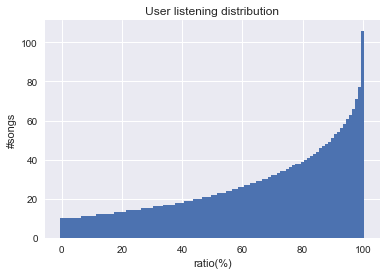

In [55]:
user_song_cnt = raw_data.groupby(['user'])['count'].count()\
                                            .reset_index(name='song_cnt')\
                                            .sort_values(['song_cnt'], ascending=False)
x = np.arange(0,1.01,0.01)
y = user_song_cnt.song_cnt.quantile(x)
plt.bar(x*100,y,width=1)
plt.xlabel('ratio(%)')
plt.ylabel('#songs')
plt.title('User listening distribution')
pass

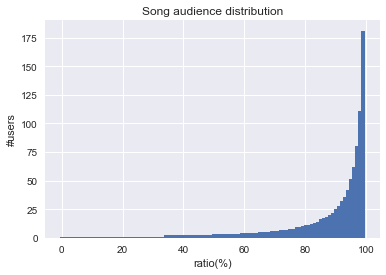

In [156]:
song_user_cnt = raw_data.groupby(['song'])['count'].count()\
                                            .reset_index(name='user_cnt')\
                                            .sort_values(['user_cnt'], ascending=False)
x = np.arange(0.,1.0,0.01)

y = song_user_cnt.user_cnt.quantile(x)
plt.bar(x*100,y,width=1)
plt.xlabel('ratio(%)')
plt.ylabel('#users')
plt.title('Song audience distribution')
pass

In [102]:
sparsities = []
training_sizes = []
itempop_hrs = []
itempop_ndcgs = []
itemcf_hrs = []
itemcf_ndcgs = []
vae_hrs = []
vae_ndcgs = []
for user_threashold in [80,40,20]:
    for song_threashold in [160,80,40]:
        train_dir = "../train/"
        dataset_name='msd-exp-'+str(user_threashold)+'-'+str(song_threashold)
        
        if not os.path.exists(os.path.join(train_dir, '%s.done' % dataset_name)):
            print 'preparing',dataset_name
            utils.data_generation(raw_data, train_dir, song_threashold, user_threashold, dataset_prefix=dataset_name)
            done_file = os.path.join(train_dir, '%s.done' % dataset_name)
            with open(done_file,'w') as f:
                f.write(str(time.time()))
        
        print 'loading',dataset_name
        
        n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
        testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
        testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
        vad_data_tr = utils.load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name),n_users, n_items)
        vad_data_te = utils.load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name),n_users, n_items)
        
        topk = 10
        limit = 10000
        
        if n_users == 0 or n_items == 0:
            continue
        
        sparsity = 1.0*train_data.count_nonzero()/(n_users*n_items)
        sparsities.append(sparsity)
        training_sizes.append(train_data.count_nonzero())
        
        # item_pop
        hr1, ndcg1 = test_item_popularity(train_data, testRatings, testNegatives, topk, limit)
        itempop_hrs.append(hr1)
        itempop_ndcgs.append(ndcg1)
        
        # itemcf
        hr2, ndcg2 = test_itemcf(dataset_name, testRatings, testNegatives, topk=topk, limit=limit)
        itemcf_hrs.append(hr2)
        itemcf_ndcgs.append(ndcg2)
        
        # vaecf
        hr3, ndcg3 = test_vaecf(n_users, n_items, train_data, vad_data_tr, vad_data_te, testRatings, testNegatives, n_epochs=50, lr=5e-4)
        vae_hrs.append(hr3)
        vae_ndcgs.append(ndcg3)
        print dataset_name, sparsity, (hr1, ndcg1), (hr2, ndcg2), (hr3, ndcg3)
        

loading msd-exp-80-160
Item Popularity, testSize=4939, HitRate=0.3353, NDCG=0.1984
ItemCF, testSize = 4939, HR = 0.5005, NDCG = 0.3216
INFO:tensorflow:Scale of 0 disables regularizer.
VAECF: epoch = 0, test_size = 4939, HR = 0.1197, NDCG = 0.0568
VAECF: epoch = 10, test_size = 4939, HR = 0.2567, NDCG = 0.1442
VAECF: epoch = 20, test_size = 4939, HR = 0.3094, NDCG = 0.1797
VAECF: epoch = 30, test_size = 4939, HR = 0.3323, NDCG = 0.1939
VAECF: epoch = 40, test_size = 4939, HR = 0.3404, NDCG = 0.1990
VAECF: test_size = 4939, HR = 0.3442, NDCG = 0.2012
msd-exp-80-160 0.00681686464277 (0.3352905446446649, 0.19841170424847648) (0.5005061753391374, 0.32156909142983936) (0.3441992306134845, 0.20115084875523673)
preparing msd-exp-80-80
loading msd-exp-80-80
Item Popularity, testSize=7445, HitRate=0.3169, NDCG=0.1928
ItemCF, testSize = 7445, HR = 0.4948, NDCG = 0.3293
INFO:tensorflow:Scale of 0 disables regularizer.
VAECF: epoch = 0, test_size = 7445, HR = 0.1257, NDCG = 0.0581
VAECF: epoch = 10

VAECF: epoch = 30, test_size = 10000, HR = 0.7803, NDCG = 0.5896
VAECF: epoch = 40, test_size = 10000, HR = 0.7730, NDCG = 0.5831
VAECF: test_size = 10000, HR = 0.7810, NDCG = 0.5901
msd-exp-20-20 0.000783353951951 (0.4044, 0.2456269148803618) (0.7954, 0.6344982025744542) (0.781, 0.5901378837889241)
preparing msd-exp-10-160
loading msd-exp-10-160
Item Popularity, testSize=10000, HitRate=0.3415, NDCG=0.2024
ItemCF, testSize = 10000, HR = 0.6727, NDCG = 0.4641
INFO:tensorflow:Scale of 0 disables regularizer.
VAECF: epoch = 0, test_size = 10000, HR = 0.3448, NDCG = 0.2057
VAECF: epoch = 10, test_size = 10000, HR = 0.6760, NDCG = 0.4617
VAECF: epoch = 20, test_size = 10000, HR = 0.6746, NDCG = 0.4592
VAECF: epoch = 30, test_size = 10000, HR = 0.6762, NDCG = 0.4597
VAECF: epoch = 40, test_size = 10000, HR = 0.6778, NDCG = 0.4603
VAECF: test_size = 10000, HR = 0.6808, NDCG = 0.4650
msd-exp-10-160 0.00276223498673 (0.3415, 0.2024338049460049) (0.6727, 0.4640574665879545) (0.6808, 0.4649977342

KeyboardInterrupt: 

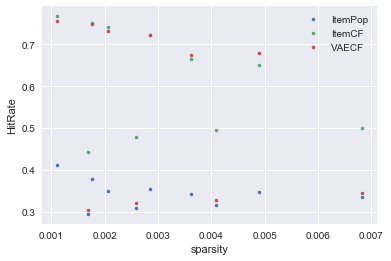

In [113]:
l = 10
plt.plot(sparsities[:l],itempop_hrs[:l],'.')
plt.plot(sparsities[:l],itemcf_hrs[:l],'.')
plt.plot(sparsities[:l],vae_hrs[:l],'.')
plt.xlabel('sparsity')
plt.ylabel('HitRate')
plt.legend(['ItemPop','ItemCF','VAECF'])
pass

In [122]:
exp_results = {}
for i in range(14):
    result = {'ItemPop': itempop_hrs[i], 'ItemCF': itemcf_hrs[i], 'VAECF': vae_hrs[i]}
    exp_results[round(sparsities[i],6)] = sorted(result.items(), key=lambda x:x[1], reverse=True)

s_exp = sorted(exp_results.items(), key=lambda x:x[0])
plot_sparsity = []
plot_itempop = []
plot_itemcf = []
plot_vae = []
for (s,r) in s_exp:
    print s,r
    if s<0.004:
        plot_sparsity.append(s)
        plot_itempop.append(dict(r)['ItemPop'])
        plot_itemcf.append(dict(r)['ItemCF'])
        plot_vae.append(dict(r)['VAECF'])

0.000783 [('ItemCF', 0.7954), ('VAECF', 0.781), ('ItemPop', 0.4044)]
0.001111 [('ItemCF', 0.7674), ('VAECF', 0.7558), ('ItemPop', 0.4116)]
0.001252 [('ItemCF', 0.7773), ('VAECF', 0.7623), ('ItemPop', 0.3713)]
0.001556 [('ItemCF', 0.7443), ('VAECF', 0.7284), ('ItemPop', 0.3435)]
0.00168 [('ItemCF', 0.4424), ('VAECF', 0.3047), ('ItemPop', 0.2947)]
0.001757 [('ItemCF', 0.7522), ('VAECF', 0.7489), ('ItemPop', 0.378)]
0.002063 [('ItemCF', 0.7406), ('VAECF', 0.7311), ('ItemPop', 0.3489)]
0.002584 [('ItemCF', 0.47846309403437814), ('VAECF', 0.3206268958543984), ('ItemPop', 0.30960566228513653)]
0.002762 [('VAECF', 0.6808), ('ItemCF', 0.6727), ('ItemPop', 0.3415)]
0.002854 [('VAECF', 0.7225), ('ItemCF', 0.7218), ('ItemPop', 0.3553)]
0.003616 [('VAECF', 0.6748), ('ItemCF', 0.6643), ('ItemPop', 0.3431)]
0.004078 [('ItemCF', 0.49482874412357286), ('VAECF', 0.3282740094022834), ('ItemPop', 0.31685695097380795)]
0.0049 [('VAECF', 0.6785), ('ItemCF', 0.6505), ('ItemPop', 0.3467)]
0.006817 [('ItemCF'

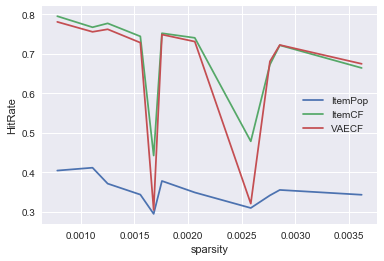

In [123]:
plt.plot(plot_sparsity,plot_itempop)
plt.plot(plot_sparsity,plot_itemcf)
plt.plot(plot_sparsity,plot_vae)
plt.xlabel('sparsity')
plt.ylabel('HitRate')
plt.legend(['ItemPop','ItemCF','VAECF'])
# 当歌曲收听数阈值低的时候，VAE 效果没那么好
pass

In [129]:
dataset_config = {'msd-little':(40,160), 'msd-user-sparse':(10,100),'msd-item-sparse':(40,40)}
for k, v in dataset_config.items():
    train_dir = "../train/"
    user_threashold = v[0]
    song_threashold = v[1]
    dataset_name=k

    if not os.path.exists(os.path.join(train_dir, '%s.done' % dataset_name)):
        print 'preparing',dataset_name
        utils.data_generation(raw_data, train_dir, song_threashold, user_threashold, dataset_prefix=dataset_name)
        done_file = os.path.join(train_dir, '%s.done' % dataset_name)
        with open(done_file,'w') as f:
            f.write(str(time.time()))


preparing msd-item-sparse


In [162]:
# test of beta
train_dir = "../train/"
k='msd-little'
user_threashold = dataset_config[k][0]
song_threashold = dataset_config[k][1]
dataset_name=k
print 'loading',dataset_name

n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
vad_data_tr = utils.load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name),n_users, n_items)
vad_data_te = utils.load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name),n_users, n_items)

topk = 10
limit = 10000

vae_hrs = {}
vae_ndcgs = {}
beta_range = [0, 0.2, 1.0]
for beta in beta_range:
    best_hr, best_ndcg, hrs, ndcgs = test_vaecf(n_users, n_items, train_data, vad_data_tr, vad_data_te, testRatings, testNegatives, n_epochs=100, lr=5e-4, batch_size=1024, hidden_dims=[1000], epoch_size=20000, beta=beta, eval_epoch=1)
    vae_hrs[beta] = hrs
    vae_ndcgs[beta] = ndcgs
    print beta, hrs, ndcgs


loading msd-little
INFO:tensorflow:Scale of 0 disables regularizer.
VAECF: epoch = 0, test_size = 10000, HR = 0.3296, NDCG = 0.1972
VAECF: epoch = 1, test_size = 10000, HR = 0.3775, NDCG = 0.2252
VAECF: epoch = 2, test_size = 10000, HR = 0.3727, NDCG = 0.2213
VAECF: epoch = 3, test_size = 10000, HR = 0.3623, NDCG = 0.2151
VAECF: epoch = 4, test_size = 10000, HR = 0.3561, NDCG = 0.2119
VAECF: epoch = 5, test_size = 10000, HR = 0.3571, NDCG = 0.2143
VAECF: epoch = 6, test_size = 10000, HR = 0.3618, NDCG = 0.2189
VAECF: epoch = 7, test_size = 10000, HR = 0.3695, NDCG = 0.2251
VAECF: epoch = 8, test_size = 10000, HR = 0.3825, NDCG = 0.2335
VAECF: epoch = 9, test_size = 10000, HR = 0.3953, NDCG = 0.2441
VAECF: epoch = 10, test_size = 10000, HR = 0.4122, NDCG = 0.2577
VAECF: epoch = 11, test_size = 10000, HR = 0.4316, NDCG = 0.2717
VAECF: epoch = 12, test_size = 10000, HR = 0.4503, NDCG = 0.2873
VAECF: epoch = 13, test_size = 10000, HR = 0.4694, NDCG = 0.3033
VAECF: epoch = 14, test_size = 1

VAECF: epoch = 0, test_size = 10000, HR = 0.3286, NDCG = 0.1962
VAECF: epoch = 1, test_size = 10000, HR = 0.3791, NDCG = 0.2258
VAECF: epoch = 2, test_size = 10000, HR = 0.3764, NDCG = 0.2224
VAECF: epoch = 3, test_size = 10000, HR = 0.3618, NDCG = 0.2149
VAECF: epoch = 4, test_size = 10000, HR = 0.3576, NDCG = 0.2123
VAECF: epoch = 5, test_size = 10000, HR = 0.3586, NDCG = 0.2144
VAECF: epoch = 6, test_size = 10000, HR = 0.3620, NDCG = 0.2188
VAECF: epoch = 7, test_size = 10000, HR = 0.3699, NDCG = 0.2248
VAECF: epoch = 8, test_size = 10000, HR = 0.3820, NDCG = 0.2335
VAECF: epoch = 9, test_size = 10000, HR = 0.3956, NDCG = 0.2443
VAECF: epoch = 10, test_size = 10000, HR = 0.4134, NDCG = 0.2585
VAECF: epoch = 11, test_size = 10000, HR = 0.4332, NDCG = 0.2733
VAECF: epoch = 12, test_size = 10000, HR = 0.4526, NDCG = 0.2881
VAECF: epoch = 13, test_size = 10000, HR = 0.4727, NDCG = 0.3052
VAECF: epoch = 14, test_size = 10000, HR = 0.4908, NDCG = 0.3204
VAECF: epoch = 15, test_size = 1000

VAECF: epoch = 0, test_size = 10000, HR = 0.3288, NDCG = 0.1974
VAECF: epoch = 1, test_size = 10000, HR = 0.3755, NDCG = 0.2255
VAECF: epoch = 2, test_size = 10000, HR = 0.3720, NDCG = 0.2210
VAECF: epoch = 3, test_size = 10000, HR = 0.3615, NDCG = 0.2143
VAECF: epoch = 4, test_size = 10000, HR = 0.3559, NDCG = 0.2116
VAECF: epoch = 5, test_size = 10000, HR = 0.3580, NDCG = 0.2146
VAECF: epoch = 6, test_size = 10000, HR = 0.3619, NDCG = 0.2186
VAECF: epoch = 7, test_size = 10000, HR = 0.3690, NDCG = 0.2246
VAECF: epoch = 8, test_size = 10000, HR = 0.3792, NDCG = 0.2329
VAECF: epoch = 9, test_size = 10000, HR = 0.3944, NDCG = 0.2433
VAECF: epoch = 10, test_size = 10000, HR = 0.4117, NDCG = 0.2566
VAECF: epoch = 11, test_size = 10000, HR = 0.4323, NDCG = 0.2720
VAECF: epoch = 12, test_size = 10000, HR = 0.4520, NDCG = 0.2869
VAECF: epoch = 13, test_size = 10000, HR = 0.4689, NDCG = 0.3031
VAECF: epoch = 14, test_size = 10000, HR = 0.4913, NDCG = 0.3202
VAECF: epoch = 15, test_size = 1000

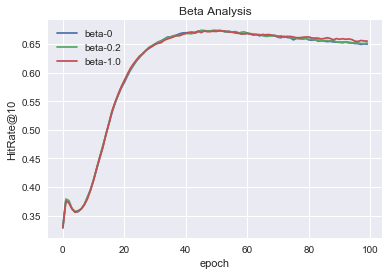

In [165]:
plt.title('Beta Analysis')

for beta in beta_range:
    plt.plot(vae_hrs[beta], label='beta-'+str(beta))

plt.ylabel('HitRate@10')
plt.xlabel('epoch')
plt.legend() # 显示图例

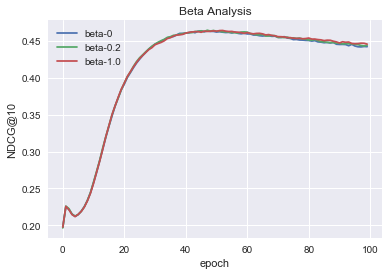

In [168]:
plt.title('Beta Analysis')

for beta in beta_range:
    plt.plot(vae_ndcgs[beta], label='beta-'+str(beta))

plt.ylabel('NDCG@10')
plt.xlabel('epoch')
plt.legend() # 显示图例

In [ ]:
sparsities = []
training_sizes = []
itempop_hrs = []
itempop_ndcgs = []
itemcf_hrs = []
itemcf_ndcgs = []
usercf_hrs = []
usercf_ndcgs = []
vae_hrs = []
vae_ndcgs = []
mf_hrs = []
mf_ndcgs = []
# 'msd-little','msd-user-sparse',
dataset_config = {'msd-little':(40,160), 'msd-user-sparse':(10,100),'msd-item-sparse':(40,40)}
for k in ['msd-item-sparse']:
    train_dir = "../train/"
    user_threashold = dataset_config[k][0]
    song_threashold = dataset_config[k][1]
    dataset_name=k
    print 'loading',dataset_name

    n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
    testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
    testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
    vad_data_tr = utils.load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name),n_users, n_items)
    vad_data_te = utils.load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name),n_users, n_items)

    topk = 10
    limit = 10000

    if n_users == 0 or n_items == 0:
        continue

    sparsity = 1.0*train_data.count_nonzero()/(n_users*n_items)
    sparsities.append(sparsity)
    training_sizes.append(train_data.count_nonzero())

    # item_pop
    hr1, ndcg1 = test_item_popularity(train_data, testRatings, testNegatives, topk, limit)
    itempop_hrs.append(hr1)
    itempop_ndcgs.append(ndcg1)

    # itemcf
    hr2, ndcg2 = test_itemcf(dataset_name, testRatings, testNegatives, topk=topk, limit=limit, Q=2)
    itemcf_hrs.append(hr2)
    itemcf_ndcgs.append(ndcg2)

    # usercf
    hr21, ndcg21 = test_usercf(dataset_name, testRatings, testNegatives, topk, limit,knn=500)
    usercf_hrs.append(hr21)
    usercf_ndcgs.append(ndcg21)

    # mf
    hr4, ndcg4 = test_mf_als(train_data, testRatings, testNegatives, n_epochs = 20, factors=64, topk=topk, limit=limit)
    mf_hrs.append(hr4)
    mf_ndcgs.append(ndcg4)
    
    # vaecf
    hr3, ndcg3, hr3, ndcg3s  = test_vaecf(n_users, n_items, train_data, vad_data_tr, vad_data_te, testRatings, testNegatives, n_epochs = 101, lr=2e-4, topk=10, limit=10000, batch_size=256, hidden_dims=[1000], beta=1, epoch_size=100000, eval_epoch=10)
    vae_hrs.append(hr3)
    vae_ndcgs.append(ndcg3)

    print dataset_name, user_threashold, song_threashold, sparsity, train_data.count_nonzero(), (hr1, ndcg1), (hr2, ndcg2), (hr3, ndcg3), (hr4, ndcg4)

loading msd-item-sparse
